In [1]:
import time
import sys
import os

import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from PIL import Image
from torchvision import models
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from scipy.stats import entropy

from torchcam.methods import *
from torchcam.utils import overlay_mask

### Indice
1. Obtención del dataset
2. Analisis del dataset
3. Preprocesamiento del dataset
4. Creacion del modelo
5. Entrenamiento del modelo
6. Prediccion del modelo
7. Evaluacion del modelo
8. Conclusiones

#### 1. Obtención del dataset

Para la realizacion del Caso Kaggle, he decidido buscar un dataset similar al del https://www.kaggle.com/kvpratama/pokemon-images-dataset, ya que para lo que tenia en mente necesitaba la variante shiny de cada pokemon.
Para ello he utilizado la siguiente pagina https://pokemondb.net/pokedex/shiny y he extraido las imagenes de todos los pokemons.  
Para ello he preparado un script en javascript que busca las imagenes de todos los pokemons y coge la url de la imagen de shiny y el normal:

    function getUrls(class_name) {
        imgs_normal = document.getElementsByClassName(class_name);
        str = "";
        for (let i = 0; i < imgs_normal.length; i++) {
            if (imgs_normal[i].src != undefined) {
                str += imgs_normal[i].src + '\n';
            }
        }
        return str;
    }

    normal = getUrls('shinydex-sprite-normal');
    shini = getUrls('shinydex-sprite-shiny');

Con este obtenemos lo siguiente:    

![img](imgs/web1.png)

Como se puede apreciar en la imagen podemos ver todas las url de las imagenes de los pokemons.  
A continuacion utilizando la libreria `requests` he descargado las imagenes de los pokemons en formato png, el codigo es el siguiente:

    import requests

    FILE_NORMAL = 'links_normal.txt'
    FILE_SHINY = 'links_shiny.txt'

    DOWNLOADED_FOLDER = '../dataset/'

    def downloader(file_name):
        lines = open(file_name, 'r').read().split('\n')
        for line in lines:
            if line == '': continue
            url = line.split('/')
            name_img = DOWNLOADED_FOLDER + url[-2] + "/" + url[-1]
            print(f'Downloading {name_img}...')
            r = requests.get(line)
            open(f'{name_img}', 'wb').write(r.content)
            
    if __name__ == '__main__':
        downloader(FILE_NORMAL)
        downloader(FILE_SHINY)

De esta manera conseguimos descargar las imagenes de los pokemons y separarlas en dos carpetas, una para las imagenes normales y otra para las imagenes shiny.

**Antes de seguir con el caso Kaggle**, tuve problemas con el modelo que escogi (Pix2Pix, que es una GAN), el principal problema que he tenido ha sido el alto coste de entrenamiento de este modelo para el problema que queria afrontar. Por ese motivo He cambiado el proposito del Kaggle, el objetivo es ver si un modelo de red neuronal, mas sencillo que el anterior mencionado es capaz de distingir entre Pokemons y Digimons. El dataset de Digimon lo he consegido del siguiente repositorio git: https://github.com/DeathReaper0965/Digimon-Generator-GAN/blob/master/Digimon.zip 

#### 2. Analisis del dataset

En este apartado vamos a analizar el dataset y ver las imagenes descargadas y su resolucion. Empezaremos creando funciones para la lectura, preprocesado y normalizacion.

In [2]:
def read_dataset_images(path, resize_size=(256, 256), add_white_bg=True):
    """
    Reads images from a directory and returns a list of images.
    """
    images = []
    for filename in os.listdir(path):
        png = Image.open(path + filename)
        png.load()
        # Cambiamos el formato de la imagen a RGB con el fondo a blanco
        if add_white_bg:
            background = Image.new("RGB", png.size, (255, 255, 255))
            background.paste(png, mask=png.split()[3])
            png = background
        # Redimensionamos la imagen
        png = png.resize(resize_size, Image.ANTIALIAS)
        images.append(np.array(png))
    return images

Tambien crearemos una funcion para mostar imagenes.

In [3]:
def show_images(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text(f'Class {lb}')
    plt.show()

def show_eval(images, n_rows_cols, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(   fig, 111,
                        nrows_ncols=(n_rows_cols, n_rows_cols),
                        axes_pad=0.4,
                    )
    for ax, im, lb in zip(grid, images, labels):
        ax.imshow(im)
        ax.title.set_text('P = %.2f D = %.2f'% (lb[0], lb[1]))
    plt.show()

def load_img(path):
  png = Image.open(path)
  png = png.resize((128, 128), Image.ANTIALIAS)
  return np.array(png)

def test_one(img):
  test = load_img(img)
  a = prepara_test_img(test)
  result = model(a)
  result = torch.sigmoid(result).cpu().detach().numpy()[0]
  print(result)
  plt.imshow(test)

In [ ]:
# Codigo para Colab
!unzip dataset.zip

In [4]:
DATASET_URL_DIGIMON = 'dataset/Digimon/'
DATASET_URL_POKEMON = 'dataset/Pokemon/normal/'

pokemon = read_dataset_images(DATASET_URL_POKEMON, (128, 128), True)
digimon = read_dataset_images(DATASET_URL_DIGIMON, (128, 128), False)

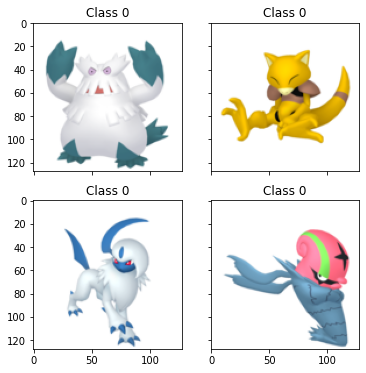

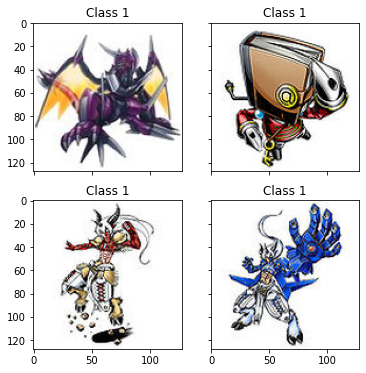

Dimension de la imagen (Pokemon):  (128, 128, 3)
Numero de imagenes (Pokemon):  895
Dimension de la imagen (Digimon):  (128, 128, 3)
Numero de imagenes (Digimon):  895


In [5]:
show_images(pokemon, 2, [0] * 4)
show_images(digimon, 2, [1] * 4)

print('Dimension de la imagen (Pokemon): ', pokemon[0].shape)
print('Numero de imagenes (Pokemon): ', len(pokemon))

print('Dimension de la imagen (Digimon): ', digimon[0].shape)
print('Numero de imagenes (Digimon): ', len(digimon))

Podemos observar que el dataset tiene la cantidad de 895 * 2 imagenes. Cada imagen tiene un tamaño de 128x128x3. En la parte superior de las imagenes tenemos los pokemons normales y en la parte inferior de las imagenes tenemos los digimons.

#### 3. Preprocesamiento del dataset

En esta apartado vamos realizar un preprocesamiento de las imagenes, como el dataset solo cuenta con 1790 imagenes y vamos a querer crear datos de train, validation y test, realizaremos un aumento de los datos y normalizacion. A continuacion vemos unas funciones para realizar este tratamiento:

In [6]:
def normalization(img):
  newX = []
  for i in img:
    newX.append(i/255)
  newX = np.stack(newX)
  newX = torch.Tensor(newX)
  return newX

def flip_image_vertical(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 1)
    return inimg

def flip_image_horizontal(inimg):
    '''
        Flipamos la imagen
    '''
    inimg = np.flip(inimg, 0)
    return inimg

def to_tensor(X):
    new = []
    trans = transforms.ToTensor()
    for x in X: new.append(trans(x))
    return torch.Tensor(new)

def change_axis(X):
    new_X = []
    for x in X:
        new_X.append(np.transpose(x, (2, 0, 1)))
    return new_X

def data_augmentation(X, y):
    new_X = []
    new_y = []
    for i in range(len(X)-2):
        x_t = flip_image_vertical(X[i])
        new_X.append(x_t)
        new_y.append(y[i])

        x_t = flip_image_horizontal(X[i+1])
        new_X.append(x_t)
        new_y.append(y[i+1])

        x_t = flip_image_vertical(X[i+2])
        x_t = flip_image_horizontal(x_t)
        new_y.append(y[i+2])
        new_X.append(x_t)

    return new_X, new_y


Una vez que tenemos las funciones definidas vamos a aplicarlas sobre nuestro dataset, pero antes vamos a separa en datos de entremiento y test, ya que las imgenes de test no quiero que sean tratadas. De las 1790 imagenes el 75% seran para entrenamiento y validacion y el 25% de test.

In [7]:
# Agrupamos en el mismo datset las imagenes de pokemon y digimon

TRAIN_SIZE = 0.70

# Agrepamos en la misma lista las imagenes
X = pokemon + digimon

# Creamos las etiquetas
y = [0] * len(pokemon) + [1] * len(digimon)

# Agremaos las imagenes y las etiquetas
dataset = list(zip(X, y))

# Mezclamos
np.random.seed(42)
np.random.shuffle(dataset)

# Separamos el dataset en X e y (y Train y Test)
X_train, y_train = zip(*dataset[:int(TRAIN_SIZE * len(dataset))])
X_test, y_test = zip(*dataset[int(TRAIN_SIZE * len(dataset)):])

In [8]:
print('Imagenes train/validacion:', len(X_train))
print('Imagenes test:', len(X_test))

Imagenes train/validacion: 1253
Imagenes test: 537


Podemos ver que nos acaba quedando 1253 imagenes de train y 537 de test. Ahora pasaremos a aplicar la normalizacion y el data-aumentation a los datos de test.

In [9]:
# Aumentamos los datos con las siguiente tranformaciones:
# Volteado vertical
# Volteado horizontal
# Los dos
X_train, y_train = data_augmentation(X_train, y_train)

# Cambiamos el axis de cada imagen, pasamos de 128, 128, 3 --> 3, 128, 128
X_train = change_axis(X_train)

# Lo pasamos a numpy array
X_train = np.stack(X_train)

# Lo pasamos a un tensor de pytorch
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).type(torch.LongTensor) # Long porque es categorico

X_train = normalization(X_train)

# Ahora lo pasamos a la clase Dataset propia de Pytorch
train_dataset = TensorDataset(X_train, y_train)
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size])

train_set = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
valid_set = DataLoader(valid_set, batch_size=1, shuffle=True, num_workers=1)

A continuacion podemos ver como ha funcionado el data-aumentation.

tensor([0.9176, 0.4235, 0.5451])


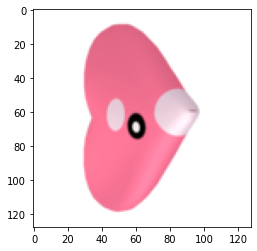

In [10]:
plt.imshow(X_train[5].permute(1, 2, 0).float())
print(X_train[5].permute(1, 2, 0)[35][35])

Finalmente nos queda las siguientes cantidades despues de aplicar data-aumentation:

In [11]:
print('Datos de entreamiento:', len(train_set)*train_set.batch_size)
print('Datos de validacion:', len(valid_set)*valid_set.batch_size)
print('Datos de test:', len(X_test))

Datos de entreamiento: 3190
Datos de validacion: 563
Datos de test: 537


#### 4. Entrenamiento del modelo

Ahora pasaremos a probar diferentes modelos a ver cual es el que mejor se ajusta a nuestro problema. Emepzaremos con el mas sencillo de los que se encuentra en los predefinidos por pytorch (son modelos populares, que dieron buenos resultados en diferentes competiciones), el primer modelo a probar sera Alexnet.

In [12]:
train_on_gpu = torch.cuda.is_available()

def alexnet():
    # Cargamos el modelo
    model = models.alexnet()
    # Modificamos la capa de salida para que solamente tenga 2 neuronas
    model.classifier[6] = nn.Linear(4096, 2)
    model.eval()
    # Mostramos el modelo
    print(model)

model = alexnet()
# Creamos el optimizador y el criterio de error
optimizer = optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

if train_on_gpu: model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Crearemos funciones para entrenar y validar nuestro modelos, asi podemos ir viendo como se entrenando nuestro modelo.

In [12]:
def train(model, optimizer, criterion, train_set, info, train_loss):
      running_loss = 0.0
      for i, data in enumerate(train_set, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          output = model(inputs)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % info == 1 and i != 0:
            sys.stdout.write(f'\rEpoca {epoch + 1} Batch {i + 1} Train loss { running_loss / info }')
            train_loss.append(running_loss / info)
            running_loss = 0.0

def validate(model, criterion, valid_set, validation_acc):                       
    correct = 0                                               
    total = 0                                                 
    running_loss = 0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate(valid_set):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
                                                              
            outputs = model(inputs)                           
            loss = criterion(outputs, labels)                 
            _, predicted = torch.max(outputs.data, 1)         
            total += labels.size(0)                           
            correct += (predicted == labels).sum().item()     
            running_loss = running_loss + loss.item()         
    mean_val_accuracy = (100 * correct / total)               
    mean_val_loss = ( running_loss )        
    print('\nValidation Accuracy: %d %%' % (mean_val_accuracy)) 
    print('Validation Loss:' , mean_val_loss )     
    validation_acc.append(mean_val_accuracy)

In [233]:
validation_acc = []
train_loss = []

for epoch in range(30):  # loop over the dataset multiple times
  train(model, optimizer, criterion, train_set, 10, train_loss)
  validate(model, criterion, valid_set, validation_acc)

print('Finished Training of AlexNet')

Epoca 1 Batch 42 Train loss 0.10595719553530217

KeyboardInterrupt: 

In [13]:
def plot_train_loss_acc(train_loss, validation_acc):
  fig=plt.figure()
  ax=fig.add_subplot(111, label="train")
  ax2=fig.add_subplot(111, label="validation", frame_on=False)

  ax.plot(train_loss, color="C0")
  ax2.plot(validation_acc, color="C1")

  ax.set_xlabel('Iteration', color="C0") 
  ax.set_ylabel('Train loss', color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")
  ax2.set_xlabel('Epoch', color="C1") 
  ax2.set_ylabel('Validation acc', color="C1")
  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.tick_params(axis='x', colors="C1")
  ax2.tick_params(axis='y', colors="C1")

  plt.show()

plot_train_loss_acc(train_loss, validation_acc)

NameError: name 'train_loss' is not defined

#### 5. Evaluacion del modelo

In [14]:
def prepara_test_img(img):
  X = img/255
  X = X.transpose((2, 0, 1))
  return torch.Tensor([X]).cuda()

def eval(X_test, y_test):
  bad_predictions = []
  good_predictions = []
  predictions = []
  for img, b in zip(X_test, y_test):
      a = prepara_test_img(img)
      result = model(a)
      result = torch.sigmoid(result).cpu().detach().numpy()[0]
      if result.argmax() != b:
        bad_predictions.append((img, result))
      else:
        good_predictions.append((img, result))
      predictions.append((b, result.argmax()))

  res = list(zip(*predictions))
  return {'predictions': res, 'good_predictions': good_predictions, 'bad_predictions': bad_predictions}

def show_acc(results):
  sn.heatmap(confusion_matrix(*results['predictions']), annot=True, fmt='g')
  plt.show()
  print(classification_report(*results['predictions']))

results = eval(X_test, y_test)

C:\Users\Juanma\AppData\Local\Temp/ipykernel_14232/3430409448.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return torch.Tensor([X]).cuda()


NameError: name 'model' is not defined

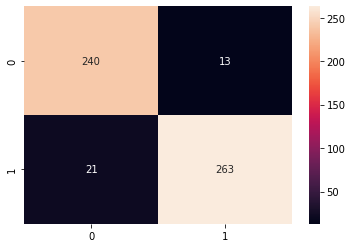

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       253
           1       0.95      0.93      0.94       284

    accuracy                           0.94       537
   macro avg       0.94      0.94      0.94       537
weighted avg       0.94      0.94      0.94       537



In [30]:
show_acc(results)

In [15]:
def eval_img(results):
  sorted_good_pokemon = sorted(results['good_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_good_digimon = sorted(results['good_predictions'], key= lambda x: x[1][1], reverse=True)

  sorted_bad_pokemon = sorted(results['bad_predictions'], key= lambda x: x[1][0], reverse=True)
  sorted_bad_digimon = sorted(results['bad_predictions'], key= lambda x: x[1][1], reverse=True)

  all_pred = sorted_good_pokemon + sorted_bad_pokemon
  all_pred = sorted(all_pred, key= lambda x: entropy(x[1]), reverse=True)

  demostration_img = [sorted_good_pokemon[0][0], sorted_good_digimon[0][0], sorted_bad_pokemon[0][0], sorted_bad_digimon[0][0]]
  demostration_lab = [sorted_good_pokemon[0][1], sorted_good_digimon[0][1], sorted_bad_pokemon[0][1], sorted_bad_digimon[0][1]]

  show_eval(demostration_img, 2, demostration_lab)
  show_eval([all_pred[0][0]], 1, [all_pred[0][1]])
  
eval_img(results)

NameError: name 'results' is not defined

Una de las cosas que podemos ver, para poder evaluar el modelos es mirar por dentro que partes de la imagen tiene mas peso como pokemon y que partes como digimos. Para ello podemos usar una herramienta parecida a Microscope de OpenIA, https://microscope.openai.com/models.
La herramienta en cuestion es GradCAM que se encuentra dentro de la libreria Torchcam.

In [226]:
cam_extractor = GradCAMpp(model, target_layer=model.avgpool)

In [16]:
def torchcam(img):
    inp = prepara_test_img(img)
    out = model(inp)
    out = torch.sigmoid(out)
    activation_map_pokemon = cam_extractor(0, out)
    activation_map_digimon = cam_extractor(1, out)

    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map_pokemon[0], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.title('Pokemon layer'); plt.show()

    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map_digimon[0], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.title('Digimon layer'); plt.show()
torchcam(X_test[90])
y_test[34]

NameError: name 'model' is not defined

#### 6. Probado otros modelos
Ahora vamos a probar otro modelo mas potente, para ver como se comporta sobre el mismo dataset.

In [19]:
def vgg():
    model = models.vgg16(init_weights=True)
    model.classifier[6]=nn.Linear(4096,2)
    return model
train_on_gpu = torch.cuda.is_available()
torch.cuda.empty_cache()
model_vgg = vgg()

validation_acc = []
train_loss = []

optimizer_inception = optim.Adam(model_vgg.parameters(), lr=0.000001)
criterion_inception = nn.CrossEntropyLoss()

if train_on_gpu: model_vgg.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(30):  # loop over the dataset multiple times
  train(model_vgg, optimizer_inception, criterion_inception, train_set, 10, train_loss)
  validate(model_vgg, criterion_inception, valid_set, validation_acc)

print('Finished Training of Inception')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1